In [1]:
#first crop and resize to 224
#check class distribution
#data agumentation for minority classes
#prepare training and validations splits 
#compute class weights  
# build DL model using suitable CNN architecture

In [3]:
#crop and resize to 224

"""
Script to crop and resize images for diabetic retinopathy detection.
This script processes retinal images by detecting the circular boundary
and cropping to focus on the retinal area.
"""

import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm


def detect_retinal_circle(image):
    """
    Detect the circular boundary of the retina in the image.
    
    Args:
        image: Input image as numpy array
        
    Returns:
        tuple: (x, y, radius) of the detected circle, or None if not found
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    
    # Use HoughCircles to detect circles
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=0,
        maxRadius=0
    )
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        # Return the largest circle
        largest_circle = max(circles, key=lambda x: x[2])
        return largest_circle
    
    return None


def crop_and_resize_image(image_path, output_path, target_size=(224, 224)):
    """
    Crop and resize a single image.
    
    Args:
        image_path: Path to input image
        output_path: Path to save processed image
        target_size: Target size for resizing (width, height)
    """
    try:
        # Load image
        image = cv2.imread(str(image_path))
        if image is None:
            print(f"Warning: Could not load image {image_path}")
            return False
            
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Detect retinal circle
        circle = detect_retinal_circle(image)
        
        if circle is not None:
            x, y, r = circle
            # Add some padding around the circle
            padding = int(r * 0.1)
            x1 = max(0, x - r - padding)
            y1 = max(0, y - r - padding)
            x2 = min(image.shape[1], x + r + padding)
            y2 = min(image.shape[0], y + r + padding)
            
            # Crop the image
            cropped = image[y1:y2, x1:x2]
        else:
            # Fallback: center crop if no circle detected
            h, w = image.shape[:2]
            min_dim = min(h, w)
            start_h = (h - min_dim) // 2
            start_w = (w - min_dim) // 2
            cropped = image[start_h:start_h+min_dim, start_w:start_w+min_dim]
        
        # Resize to target size
        resized = cv2.resize(cropped, target_size)
        
        # Convert back to BGR for saving
        resized_bgr = cv2.cvtColor(resized, cv2.COLOR_RGB2BGR)
        
        # Save the processed image
        Path(output_path).parent.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(str(output_path), resized_bgr)
        
        return True
        
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return False


def process_directory(src_dir, dst_dir, target_size=(224, 224)):
    """
    Process all images in a directory (recursively).
    
    Args:
        src_dir: Source directory containing images
        dst_dir: Destination directory for processed images
        target_size: Target size for resizing
    """
    src_path = Path(src_dir)
    dst_path = Path(dst_dir)
    
    # Create destination directory
    dst_path.mkdir(parents=True, exist_ok=True)
    
    # Get all image files recursively
    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}
    image_files = []
    for ext in image_extensions:
        image_files.extend(src_path.rglob(f"*{ext}"))
        image_files.extend(src_path.rglob(f"*{ext.upper()}"))
    
    print(f"Found {len(image_files)} images to process")
    
    # Process each image
    successful = 0
    failed = 0
    
    for image_file in tqdm(image_files, desc="Processing images"):
        # Create corresponding output path mirroring the structure
        rel_path = image_file.relative_to(src_path)
        output_file = dst_path / rel_path
        
        # Process the image
        if crop_and_resize_image(image_file, output_file, target_size):
            successful += 1
        else:
            failed += 1
    
    print("Processing complete!")
    print(f"Successfully processed: {successful}")
    print(f"Failed: {failed}")



In [4]:
# Runner cell for notebook use
# Set your source and destination directories here
src_dir = r"C:\Users\KIRITI\Downloads\DR\Dataset_DR"
dst_dir = r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224"

# Choose target size (width, height)
size = (224, 224)

process_directory(src_dir, dst_dir, target_size=size)


Found 5500 images to process


Processing images: 100%|██████████| 5500/5500 [01:26<00:00, 63.40it/s] 

Processing complete!
Successfully processed: 5500
Failed: 0


In [5]:
# EDA utilities for processed dataset
from collections import Counter, defaultdict
import json
import math
import matplotlib.pyplot as plt

IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}


def is_image_file(path: Path) -> bool:
    return path.suffix.lower() in IMAGE_EXTS


def scan_dataset(root_dir: str):
    """
    Walk the processed dataset, returning:
    - class_to_files: dict[class_name -> list[Path]]
    - corrupt_files: list[Path]
    - image_shapes: dict[class_name -> Counter of shapes]
    """
    root = Path(root_dir)
    class_to_files = defaultdict(list)
    corrupt_files = []
    image_shapes = defaultdict(Counter)

    for class_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
        class_name = class_dir.name
        for p in class_dir.rglob('*'):
            if p.is_file() and is_image_file(p):
                # basic corruption check by attempting load
                img = cv2.imread(str(p))
                if img is None:
                    corrupt_files.append(p)
                    continue
                class_to_files[class_name].append(p)
                image_shapes[class_name][img.shape] += 1

    return class_to_files, corrupt_files, image_shapes


def compute_class_counts(class_to_files):
    return {cls: len(files) for cls, files in class_to_files.items()}


def compute_imbalance_metrics(class_counts: dict):
    """
    Returns metrics helpful for imbalance assessment.
    - num_classes, total_images, min/max/mean per class
    - majority_ratio (max/min), gini coefficient, entropy
    """
    counts = list(class_counts.values())
    if not counts:
        return {}
    total = sum(counts)
    k = len(counts)
    c_min, c_max = min(counts), max(counts)
    mean = total / k

    # Majority ratio
    majority_ratio = c_max / max(1, c_min)

    # Gini coefficient (discrete distribution)
    sorted_counts = sorted(counts)
    cum = 0
    for i, x in enumerate(sorted_counts, start=1):
        cum += i * x
    gini = (2 * cum) / (k * total) - (k + 1) / k if total > 0 else 0.0

    # Entropy (normalized by log(k))
    probs = [c / total for c in counts]
    entropy = -sum(p * math.log(p + 1e-12) for p in probs)
    entropy_norm = entropy / math.log(k) if k > 1 else 0.0

    return {
        'num_classes': k,
        'total_images': total,
        'min_per_class': c_min,
        'max_per_class': c_max,
        'mean_per_class': mean,
        'majority_ratio': majority_ratio,
        'gini': gini,
        'entropy_norm': entropy_norm,
    }


def save_imbalance_report(report_path: str, class_counts: dict, metrics: dict, corrupt_files: list):
    report = {
        'class_counts': class_counts,
        'metrics': metrics,
        'num_corrupt_files': len(corrupt_files),
        'corrupt_files': [str(p) for p in corrupt_files[:50]],  # limit
    }
    Path(report_path).parent.mkdir(parents=True, exist_ok=True)
    with open(report_path, 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2)
    return report_path


def plot_class_distribution(class_counts: dict, title: str = 'Class distribution'):
    classes = list(class_counts.keys())
    values = [class_counts[c] for c in classes]
    plt.figure(figsize=(8, 4))
    bars = plt.bar(classes, values, color='#4C78A8')
    plt.title(title)
    plt.ylabel('Num images')
    plt.xticks(rotation=30, ha='right')
    for bar, v in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(v), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


def print_markdown_summary(class_counts: dict, metrics: dict, corrupt_files: list):
    from IPython.display import Markdown, display
    lines = []
    lines.append(f"**Classes**: {metrics.get('num_classes', 0)}  ")
    lines.append(f"**Total images**: {metrics.get('total_images', 0)}  ")
    lines.append(f"**Min/Max/Mean per class**: {metrics.get('min_per_class', 0)} / {metrics.get('max_per_class', 0)} / {metrics.get('mean_per_class', 0):.2f}  ")
    lines.append(f"**Majority ratio (max/min)**: {metrics.get('majority_ratio', 0):.2f}  ")
    lines.append(f"**Gini**: {metrics.get('gini', 0):.3f}  |  **Entropy (norm)**: {metrics.get('entropy_norm', 0):.3f}  ")
    lines.append(f"**Corrupt files**: {len(corrupt_files)}  ")
    display(Markdown("\n".join(lines)))



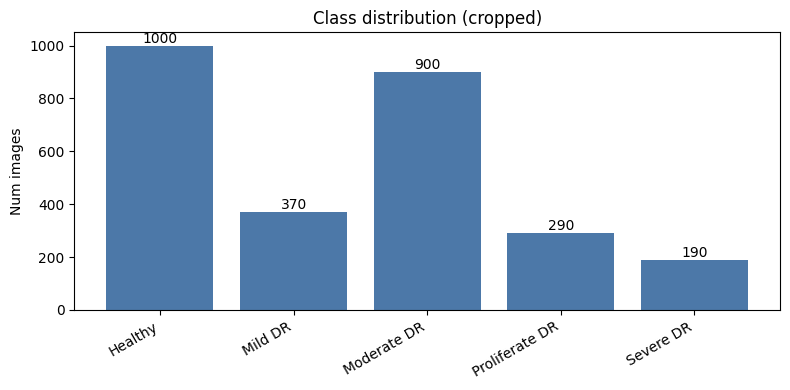

**Classes**: 5  
**Total images**: 2750  
**Min/Max/Mean per class**: 190 / 1000 / 550.00  
**Majority ratio (max/min)**: 5.26  
**Gini**: 0.324  |  **Entropy (norm)**: 0.885  
**Corrupt files**: 0  

Saved EDA report to: C:\Users\KIRITI\Downloads\DR\Dataset_DR_224\eda_report.json


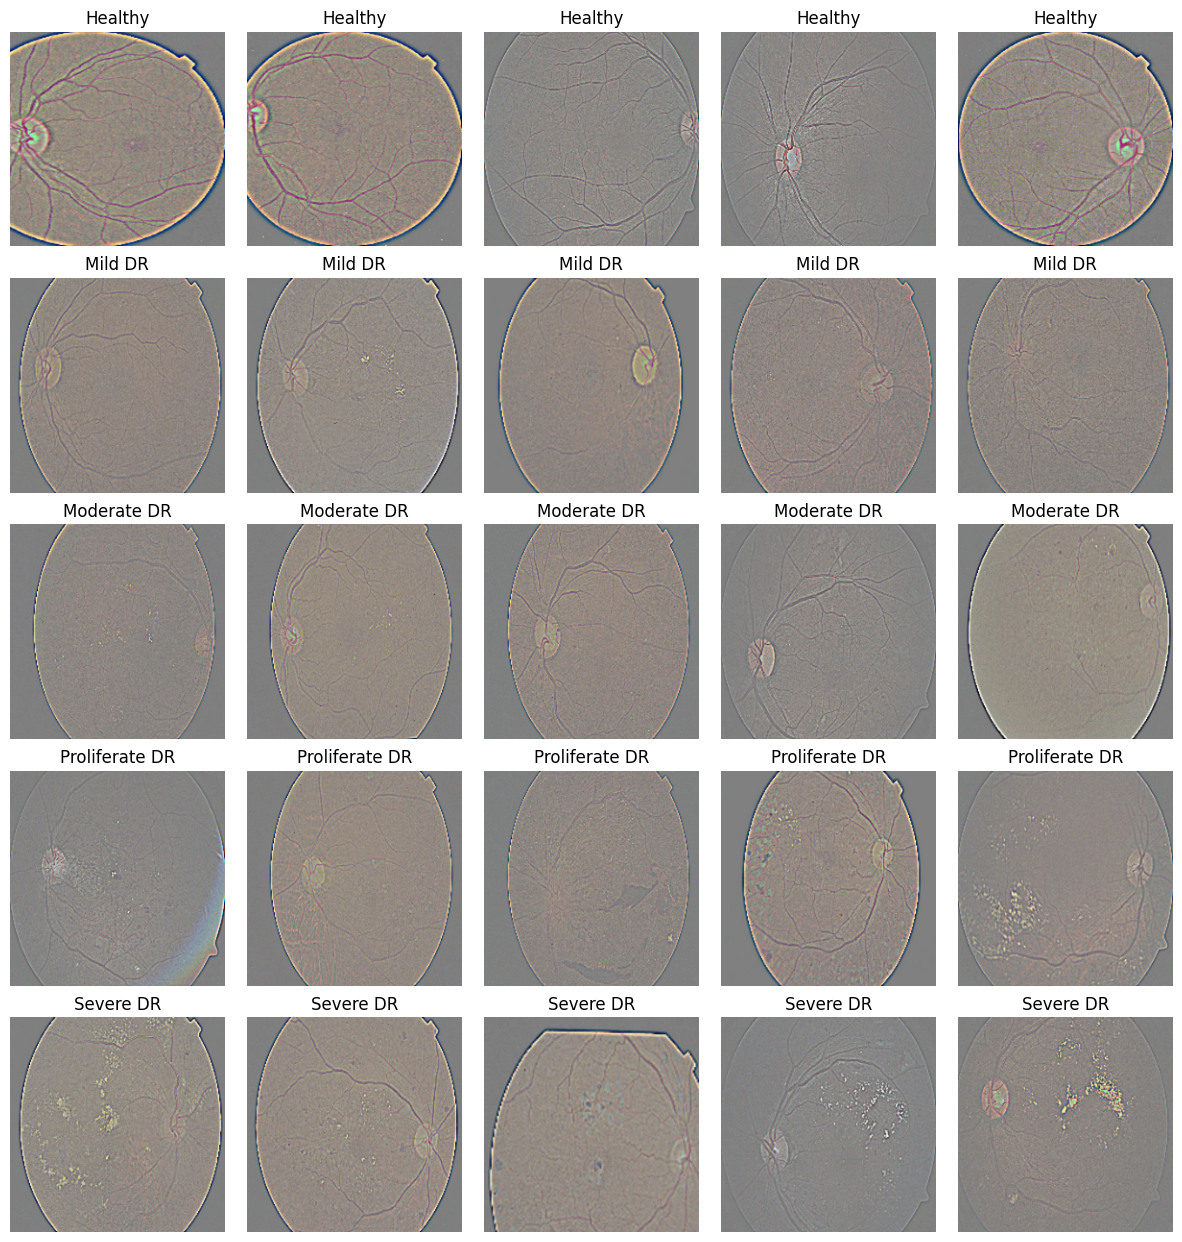

In [6]:
# EDA runner and visualization
processed_dir = r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224"  # use the cropped folder

class_to_files, corrupt_files, image_shapes = scan_dataset(processed_dir)
class_counts = compute_class_counts(class_to_files)
metrics = compute_imbalance_metrics(class_counts)

# Show class distribution bar chart
plot_class_distribution(class_counts, title='Class distribution (cropped)')

# Markdown summary
print_markdown_summary(class_counts, metrics, corrupt_files)

# Save a JSON report alongside the dataset
report_path = str(Path(processed_dir) / "eda_report.json")
save_imbalance_report(report_path, class_counts, metrics, corrupt_files)
print(f"Saved EDA report to: {report_path}")

# Optional: preview a few images per class
from itertools import islice
fig, axes = plt.subplots(nrows=len(class_counts), ncols=5, figsize=(12, 2.5*max(1, len(class_counts))))
if len(class_counts) == 1:
    axes = [axes]
for row_idx, cls in enumerate(sorted(class_counts.keys())):
    sample_paths = list(islice(class_to_files[cls], 5))
    for col_idx in range(5):
        ax = axes[row_idx][col_idx] if len(class_counts) > 1 else axes[col_idx]
        ax.axis('off')
        if col_idx < len(sample_paths):
            img = cv2.cvtColor(cv2.imread(str(sample_paths[col_idx])), cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(cls)
plt.tight_layout()
plt.show()


In [7]:
# EDA with pandas + seaborn + matplotlib (no custom helpers)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

# Point to the processed (cropped/resized) dataset folder
processed_dir = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224")

rows = []
for class_dir in sorted([d for d in processed_dir.iterdir() if d.is_dir()]):
    cls = class_dir.name
    for p in class_dir.rglob('*'):
        if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}:
            width, height = None, None
            corrupt = False
            try:
                with Image.open(p) as im:
                    width, height = im.size
            except Exception:
                corrupt = True
            rows.append({
                'path': str(p),
                'class': cls,
                'ext': p.suffix.lower(),
                'size_bytes': p.stat().st_size if p.exists() else np.nan,
                'width': width,
                'height': height,
                'corrupt': corrupt,
            })

df = pd.DataFrame(rows)
print(f"Scanned files: {len(df)}  |  Corrupt: {df['corrupt'].sum()}")

# Save a simple CSV snapshot
summary_csv = processed_dir / 'eda_files_snapshot.csv'
df.to_csv(summary_csv, index=False)
print(f"Saved file list to: {summary_csv}")


Scanned files: 2750  |  Corrupt: 0
Saved file list to: C:\Users\KIRITI\Downloads\DR\Dataset_DR_224\eda_files_snapshot.csv


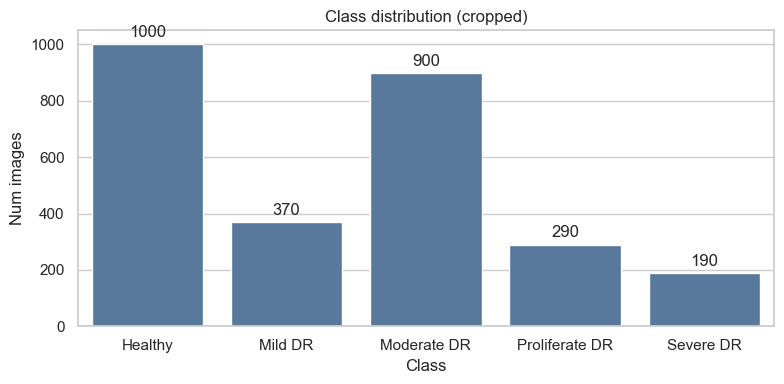

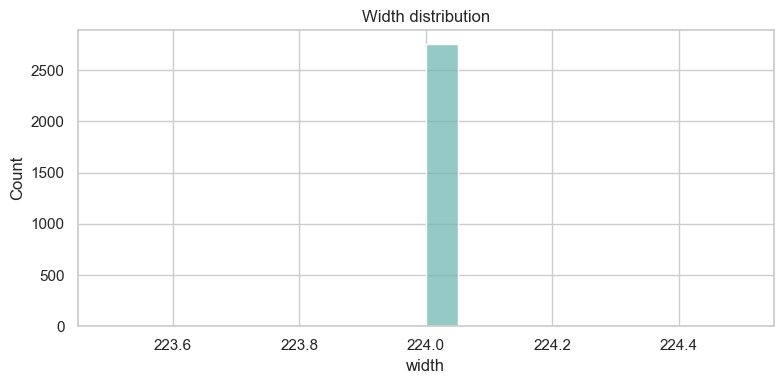

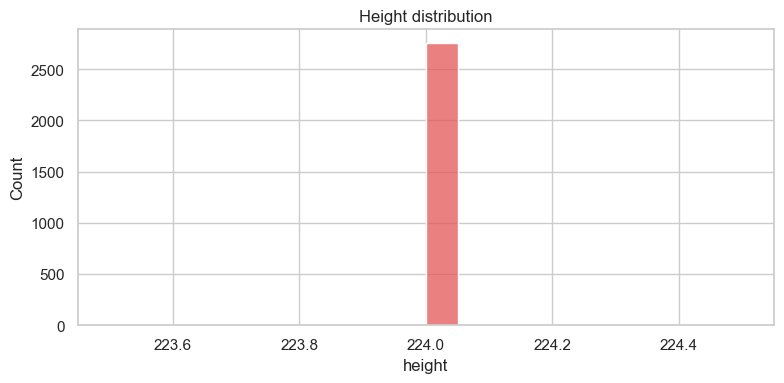

{'num_classes': 5, 'total_images': 2750, 'min_per_class': 190, 'max_per_class': 1000, 'mean_per_class': 550.0, 'majority_ratio': 5.2631578947368425, 'gini': 0.3243636363636364, 'entropy_norm': 0.8854865132704347, 'corrupt_files': 0}


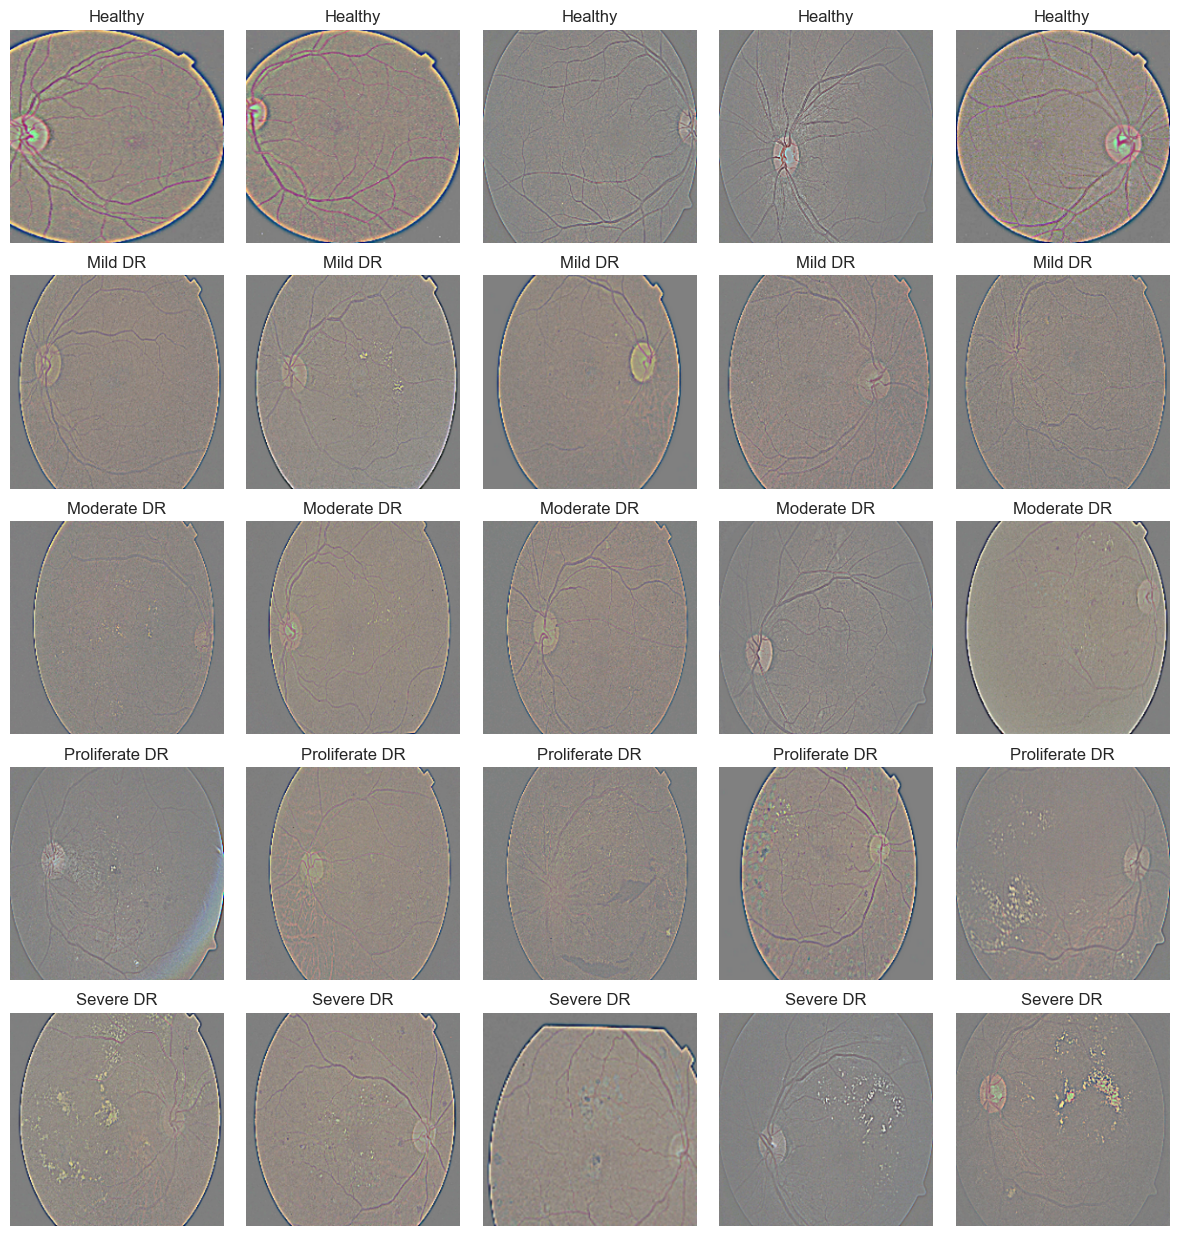

In [8]:
# Standard plots and imbalance metrics with seaborn/matplotlib
sns.set_theme(style='whitegrid')

# Filter to non-corrupt files
clean_df = df[~df['corrupt']].copy()

# Class counts barplot
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=clean_df, x='class', order=sorted(clean_df['class'].unique()), color='#4C78A8')
plt.title('Class distribution (cropped)')
plt.xlabel('Class')
plt.ylabel('Num images')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')
plt.tight_layout()
plt.show()

# Image dimension checks
plt.figure(figsize=(8, 4))
sns.histplot(clean_df['width'], bins=20, color='#72B7B2')
plt.title('Width distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(clean_df['height'], bins=20, color='#E45756')
plt.title('Height distribution')
plt.tight_layout()
plt.show()

# Compute imbalance metrics using pandas
class_counts = clean_df.groupby('class')['path'].count().rename('count')
counts = class_counts.values
k = len(counts)

total = counts.sum()
min_c, max_c = counts.min(), counts.max()
mean_c = counts.mean()
majority_ratio = (max_c / min_c) if min_c > 0 else np.inf

sorted_counts = np.sort(counts)
gini = (2 * (np.arange(1, k+1) * sorted_counts).sum()) / (k * total) - (k + 1) / k if total > 0 else 0.0
probs = counts / total if total > 0 else np.zeros_like(counts)
entropy = -(probs * np.log(probs + 1e-12)).sum()
entropy_norm = (entropy / np.log(k)) if k > 1 else 0.0

print({
    'num_classes': int(k),
    'total_images': int(total),
    'min_per_class': int(min_c),
    'max_per_class': int(max_c),
    'mean_per_class': float(mean_c),
    'majority_ratio': float(majority_ratio),
    'gini': float(gini),
    'entropy_norm': float(entropy_norm),
    'corrupt_files': int(df['corrupt'].sum()),
})

# Optional: pair of example images per class
from itertools import islice
n_cols = 5
n_rows = len(class_counts)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 2.5*max(1, n_rows)))
if n_rows == 1:
    axes = [axes]
for row_idx, cls in enumerate(class_counts.sort_index().index):
    paths = list(islice(clean_df[clean_df['class'] == cls]['path'].values, n_cols))
    for col_idx in range(n_cols):
        ax = axes[row_idx][col_idx] if n_rows > 1 else axes[col_idx]
        ax.axis('off')
        if col_idx < len(paths):
            img = np.array(Image.open(paths[col_idx]).convert('RGB'))
            ax.imshow(img)
            ax.set_title(cls)
plt.tight_layout()
plt.show()


In [18]:
# OpenCV-only augmentation (no albumentations): uniform policy + balance to majority
from pathlib import Path
import random, math
from collections import defaultdict
import numpy as np
import cv2
from tqdm import tqdm

SRC_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224")
OUT_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224_aug_cv2")
TARGET_SIZE = (224, 224)  # (w, h)
BASE_FRACTION = 0.25      # fraction generated for ALL classes
SEED = 42

random.seed(SEED); np.random.seed(SEED)
IMG_EXT = {'.jpg','.jpeg','.png','.bmp','.tiff','.tif'}


def random_flip(img_bgr):
    if random.random() < 0.5:
        img_bgr = cv2.flip(img_bgr, 1)
    return img_bgr


def random_rotate(img_bgr, max_deg=15):
    angle = random.uniform(-max_deg, max_deg)
    h, w = img_bgr.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img_bgr, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)


def random_resized_crop(img_bgr, scale=(0.85, 1.0), ratio=(0.95, 1.05)):
    h, w = img_bgr.shape[:2]
    area = h * w
    for _ in range(10):
        target_area = random.uniform(*scale) * area
        log_ratio = (np.log(ratio[0]), np.log(ratio[1]))
        aspect = np.exp(random.uniform(*log_ratio))
        new_w = int(round(np.sqrt(target_area * aspect)))
        new_h = int(round(np.sqrt(target_area / aspect)))
        if 0 < new_w <= w and 0 < new_h <= h:
            x1 = random.randint(0, w - new_w)
            y1 = random.randint(0, h - new_h)
            crop = img_bgr[y1:y1+new_h, x1:x1+new_w]
            return cv2.resize(crop, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    return cv2.resize(img_bgr, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)


def color_jitter_bgr(img_bgr, max_brightness=0.08, max_contrast=0.08, max_saturation=0.05, max_hue=0.02):
    img = img_bgr.astype(np.float32) / 255.0
    # brightness
    if max_brightness > 0:
        b = random.uniform(-max_brightness, max_brightness)
        img = np.clip(img + b, 0.0, 1.0)
    # contrast
    if max_contrast > 0:
        c = 1.0 + random.uniform(-max_contrast, max_contrast)
        img = np.clip((img - 0.5) * c + 0.5, 0.0, 1.0)
    img = (img * 255.0).astype(np.uint8)
    # saturation & hue (in HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    if max_saturation > 0:
        s_factor = 1.0 + random.uniform(-max_saturation, max_saturation)
        hsv[...,1] = np.clip(hsv[...,1] * s_factor, 0, 255)
    if max_hue > 0:
        h_shift = int(180 * random.uniform(-max_hue, max_hue))
        hsv[...,0] = (hsv[...,0] + h_shift) % 180
    img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return img


def augment_once(img_bgr):
    img_bgr = random_flip(img_bgr)
    if random.random() < 0.8:
        img_bgr = random_rotate(img_bgr, max_deg=15)
    if random.random() < 0.7:
        img_bgr = random_resized_crop(img_bgr, scale=(0.85, 1.0), ratio=(0.95, 1.05))
    else:
        img_bgr = cv2.resize(img_bgr, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    if random.random() < 0.6:
        img_bgr = color_jitter_bgr(img_bgr)
    else:
        img_bgr = cv2.resize(img_bgr, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    return img_bgr

# Gather files per class
class_to_files = {d.name: [p for p in d.rglob('*') if p.suffix.lower() in IMG_EXT]
                  for d in sorted(SRC_DIR.iterdir()) if d.is_dir()}
counts = {c: len(fs) for c, fs in class_to_files.items()}
if not counts: raise SystemExit('No classes found')
majority = max(counts.values())
print('Original counts:', counts)
print('Majority count:', majority)

# Decide how many to generate per class
to_generate = {}
for cls, n in counts.items():
    base = math.ceil(n * BASE_FRACTION)
    extra = max(0, majority - (n + base))
    to_generate[cls] = base + extra
print('Will generate per class:', to_generate)

# Generate and save
OUT_DIR.mkdir(parents=True, exist_ok=True)
gen_counts = defaultdict(int)
for cls, files in class_to_files.items():
    out_cls = OUT_DIR / cls
    out_cls.mkdir(parents=True, exist_ok=True)
    total = to_generate[cls]
    if total <= 0 or not files: continue
    for i in tqdm(range(total), desc=f'Augment {cls}'):
        src = random.choice(files)
        img = cv2.imread(str(src))  # BGR
        if img is None: continue
        aug_img = augment_once(img)
        out_name = f"{src.stem}_aug_{i:05d}{src.suffix.lower()}"
        cv2.imwrite(str(out_cls / out_name), aug_img)
        gen_counts[cls] += 1

print('\n=== OpenCV Augmentation Summary ===')
for cls in sorted(counts.keys()):
    print(f"- {cls}: original={counts[cls]}, generated={gen_counts[cls]}, final_total_if_combined={counts[cls]+gen_counts[cls]}")
print('Augmented images saved under:', OUT_DIR)


Original counts: {'Healthy': 1000, 'Mild DR': 370, 'Moderate DR': 900, 'Proliferate DR': 290, 'Severe DR': 190}
Majority count: 1000
Will generate per class: {'Healthy': 250, 'Mild DR': 630, 'Moderate DR': 225, 'Proliferate DR': 710, 'Severe DR': 810}


Augment Severe DR: 100%|██████████| 810/810 [00:05<00:00, 160.34it/s]


=== OpenCV Augmentation Summary ===
- Healthy: original=1000, generated=250, final_total_if_combined=1250
- Mild DR: original=370, generated=630, final_total_if_combined=1000
- Moderate DR: original=900, generated=225, final_total_if_combined=1125
- Proliferate DR: original=290, generated=710, final_total_if_combined=1000
- Severe DR: original=190, generated=810, final_total_if_combined=1000
Augmented images saved under: C:\Users\KIRITI\Downloads\DR\Dataset_DR_224_aug_cv2


In [21]:
# Exact balancing: copy originals then augment deficits to match a single target per class
from pathlib import Path
import random, math
from collections import defaultdict
import numpy as np
import cv2
from tqdm import tqdm

SRC_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224")
BAL_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224_balanced_cv2")
TARGET_SIZE = (224, 224)  # (w, h)
SEED = 42
# Optional: force a specific target per class (e.g., 810). Set to None to use max original count.
TARGET_PER_CLASS = None  # e.g., 810

random.seed(SEED); np.random.seed(SEED)
IMG_EXT = {'.jpg','.jpeg','.png','.bmp','.tiff','.tif'}

# --- simple CV2 augmentations (same policy for all classes) ---
def random_flip(img_bgr):
    if random.random() < 0.5:
        img_bgr = cv2.flip(img_bgr, 1)
    return img_bgr

def random_rotate(img_bgr, max_deg=15):
    angle = random.uniform(-max_deg, max_deg)
    h, w = img_bgr.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img_bgr, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT101)

def random_resized_crop(img_bgr, scale=(0.85, 1.0), ratio=(0.95, 1.05)):
    h, w = img_bgr.shape[:2]
    area = h * w
    for _ in range(10):
        target_area = random.uniform(*scale) * area
        log_ratio = (np.log(ratio[0]), np.log(ratio[1]))
        aspect = np.exp(random.uniform(*log_ratio))
        new_w = int(round(np.sqrt(target_area * aspect)))
        new_h = int(round(np.sqrt(target_area / aspect)))
        if 0 < new_w <= w and 0 < new_h <= h:
            x1 = random.randint(0, w - new_w)
            y1 = random.randint(0, h - new_h)
            crop = img_bgr[y1:y1+new_h, x1:x1+new_w]
            return cv2.resize(crop, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    return cv2.resize(img_bgr, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)

def color_jitter_bgr(img_bgr, max_brightness=0.08, max_contrast=0.08, max_saturation=0.05, max_hue=0.02):
    img = img_bgr.astype(np.float32) / 255.0
    if max_brightness > 0:
        b = random.uniform(-max_brightness, max_brightness)
        img = np.clip(img + b, 0.0, 1.0)
    if max_contrast > 0:
        c = 1.0 + random.uniform(-max_contrast, max_contrast)
        img = np.clip((img - 0.5) * c + 0.5, 0.0, 1.0)
    img = (img * 255.0).astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    if max_saturation > 0:
        s_factor = 1.0 + random.uniform(-max_saturation, max_saturation)
        hsv[...,1] = np.clip(hsv[...,1] * s_factor, 0, 255)
    if max_hue > 0:
        h_shift = int(180 * random.uniform(-max_hue, max_hue))
        hsv[...,0] = (hsv[...,0] + h_shift) % 180
    img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return img

def augment_once(img_bgr):
    img_bgr = random_flip(img_bgr)
    if random.random() < 0.8:
        img_bgr = random_rotate(img_bgr, max_deg=15)
    if random.random() < 0.7:
        img_bgr = random_resized_crop(img_bgr, scale=(0.85, 1.0), ratio=(0.95, 1.05))
    else:
        img_bgr = cv2.resize(img_bgr, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    if random.random() < 0.6:
        img_bgr = color_jitter_bgr(img_bgr)
    else:
        img_bgr = cv2.resize(img_bgr, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
    return img_bgr

# --- collect originals per class ---
class_to_files = {d.name: [p for p in d.rglob('*') if p.suffix.lower() in IMG_EXT]
                  for d in sorted(SRC_DIR.iterdir()) if d.is_dir()}
orig_counts = {c: len(fs) for c, fs in class_to_files.items()}
if not orig_counts:
    raise SystemExit('No classes found')
max_orig = max(orig_counts.values())
TARGET = int(TARGET_PER_CLASS) if TARGET_PER_CLASS else max_orig
print('Original counts:', orig_counts)
print('Target per class:', TARGET)

# --- copy originals into BAL_DIR ---
for cls, files in class_to_files.items():
    out_cls = BAL_DIR / cls
    out_cls.mkdir(parents=True, exist_ok=True)
    for p in tqdm(files, desc=f'Copy originals: {cls}'):
        img = cv2.imread(str(p))
        if img is None: continue
        img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_LINEAR)
        out_path = out_cls / p.name
        cv2.imwrite(str(out_path), img)

# --- augment deficits to reach TARGET ---
gen_counts = defaultdict(int)
for cls, files in class_to_files.items():
    need = TARGET - len(files)
    if need <= 0 or not files: continue
    out_cls = BAL_DIR / cls
    for i in tqdm(range(need), desc=f'Augment to target: {cls}'):
        src = random.choice(files)
        img = cv2.imread(str(src))
        if img is None: continue
        aug_img = augment_once(img)
        out_name = f"{src.stem}_aug_{i:05d}{src.suffix.lower()}"
        cv2.imwrite(str(out_cls / out_name), aug_img)
        gen_counts[cls] += 1

# --- summary ---
final_counts = {}
for d in sorted(p for p in BAL_DIR.iterdir() if p.is_dir()):
    final_counts[d.name] = sum(1 for p in d.rglob('*') if p.suffix.lower() in IMG_EXT)

print('\n=== Exact Balancing Summary ===')
for cls in sorted(orig_counts.keys()):
    print(f"- {cls}: original={orig_counts[cls]}, generated={gen_counts[cls]}, final={final_counts.get(cls, 0)}")
print('Balanced dataset saved under:', BAL_DIR)


Original counts: {'Healthy': 1000, 'Mild DR': 370, 'Moderate DR': 900, 'Proliferate DR': 290, 'Severe DR': 190}
Target per class: 1000


Augment to target: Severe DR: 100%|██████████| 810/810 [00:04<00:00, 166.81it/s]


=== Exact Balancing Summary ===
- Healthy: original=1000, generated=0, final=1000
- Mild DR: original=370, generated=630, final=1000
- Moderate DR: original=900, generated=100, final=1000
- Proliferate DR: original=290, generated=710, final=1000
- Severe DR: original=190, generated=810, final=1000
Balanced dataset saved under: C:\Users\KIRITI\Downloads\DR\Dataset_DR_224_balanced_cv2


Total augmented files: 5000


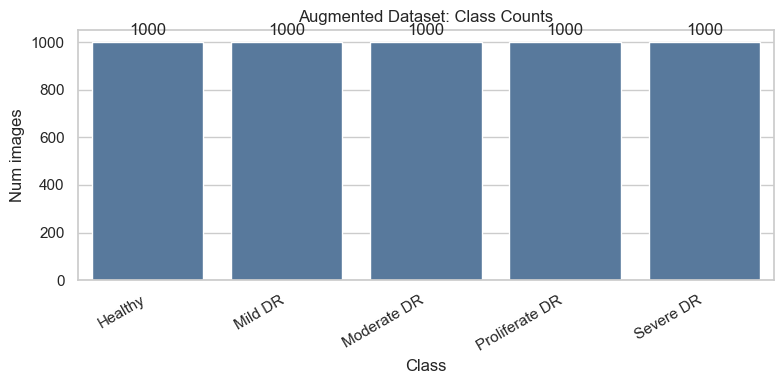

In [23]:
# Class imbalance bar chart for augmented dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Point to your augmented folder (choose the one you ran)
aug_dir = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224_balanced_cv2")  # or _aug_minimal / _aug_uniform

rows = []
for class_dir in sorted([d for d in aug_dir.iterdir() if d.is_dir()]):
    cls = class_dir.name
    for p in class_dir.rglob('*'):
        if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}:
            rows.append({'class': cls, 'path': str(p)})

df_aug = pd.DataFrame(rows)
if df_aug.empty:
    print('No images found in augmented folder:', aug_dir)
else:
    counts = df_aug.groupby('class')['path'].count().reset_index(name='count')
    counts = counts.sort_values('class')
    print('Total augmented files:', counts['count'].sum())

    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(data=counts, x='class', y='count', color='#4C78A8')
    plt.title('Augmented Dataset: Class Counts')
    plt.xlabel('Class')
    plt.ylabel('Num images')
    plt.xticks(rotation=30, ha='right')
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')
    plt.tight_layout()
    plt.show()


<b>Splitting</b>

In [24]:
# Stratified train/val split (mirrors class folders + CSV manifests)
from pathlib import Path
import random, shutil
from collections import Counter
import pandas as pd

# Source dataset to split (balanced or any processed set with class subfolders)
SRC_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224_balanced_cv2")
OUT_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\splits")
VAL_FRACTION = 0.2
SEED = 42

random.seed(SEED)
IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

# Collect files per class
class_to_files = {}
for d in sorted(p for p in SRC_DIR.iterdir() if p.is_dir()):
    class_to_files[d.name] = [p for p in d.rglob('*') if p.is_file() and p.suffix.lower() in IMG_EXT]

if not class_to_files:
    raise SystemExit(f"No classes found under {SRC_DIR}")

# Prepare output
train_dir = OUT_DIR / "train"
val_dir = OUT_DIR / "val"
train_dir.mkdir(parents=True, exist_ok=True)
val_dir.mkdir(parents=True, exist_ok=True)

# Split and copy
splits = {"train": [], "val": []}
for cls, files in class_to_files.items():
    files = sorted(files)
    random.shuffle(files)
    n_val = int(round(len(files) * VAL_FRACTION))
    val_files, train_files = files[:n_val], files[n_val:]

    for p in train_files:
        dst = train_dir / cls / p.name
        dst.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(p, dst)
        splits["train"].append({"split": "train", "class": cls, "path": str(dst)})

    for p in val_files:
        dst = val_dir / cls / p.name
        dst.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(p, dst)
        splits["val"].append({"split": "val", "class": cls, "path": str(dst)})

# Save CSV manifests
train_csv = OUT_DIR / "train_manifest.csv"
val_csv = OUT_DIR / "val_manifest.csv"
pd.DataFrame(splits["train"]).to_csv(train_csv, index=False)
pd.DataFrame(splits["val"]).to_csv(val_csv, index=False)

# Summary
train_counts = Counter([r["class"] for r in splits["train"]])
val_counts = Counter([r["class"] for r in splits["val"]])
print("Train counts per class:", dict(sorted(train_counts.items())))
print("Val counts per class  :", dict(sorted(val_counts.items())))
print("Output folders:", train_dir, "|", val_dir)
print("Manifests:", train_csv, "|", val_csv)

Train counts per class: {'Healthy': 800, 'Mild DR': 800, 'Moderate DR': 800, 'Proliferate DR': 800, 'Severe DR': 800}
Val counts per class  : {'Healthy': 200, 'Mild DR': 200, 'Moderate DR': 200, 'Proliferate DR': 200, 'Severe DR': 200}
Output folders: C:\Users\KIRITI\Downloads\DR\splits\train | C:\Users\KIRITI\Downloads\DR\splits\val
Manifests: C:\Users\KIRITI\Downloads\DR\splits\train_manifest.csv | C:\Users\KIRITI\Downloads\DR\splits\val_manifest.csv


Total augmented files: 4000


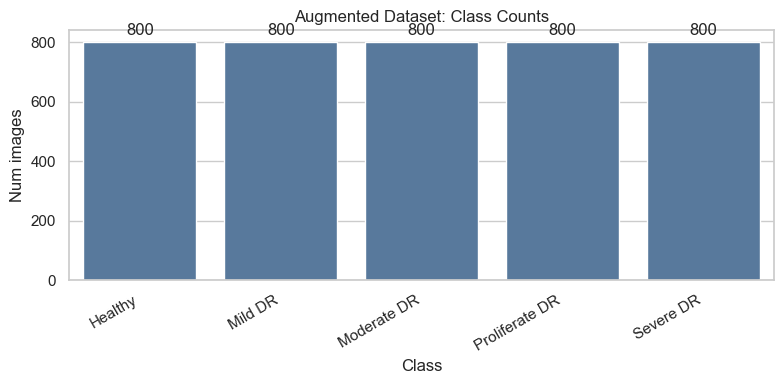

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Point to your augmented folder (choose the one you ran)
aug_dir = Path(r"C:\Users\KIRITI\Downloads\DR\splits\train")  # or _aug_minimal / _aug_uniform

rows = []
for class_dir in sorted([d for d in aug_dir.iterdir() if d.is_dir()]):
    cls = class_dir.name
    for p in class_dir.rglob('*'):
        if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}:
            rows.append({'class': cls, 'path': str(p)})

df_aug = pd.DataFrame(rows)
if df_aug.empty:
    print('No images found in augmented folder:', aug_dir)
else:
    counts = df_aug.groupby('class')['path'].count().reset_index(name='count')
    counts = counts.sort_values('class')
    print('Total augmented files:', counts['count'].sum())

    sns.set_theme(style='whitegrid')
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(data=counts, x='class', y='count', color='#4C78A8')
    plt.title('Augmented Dataset: Class Counts')
    plt.xlabel('Class')
    plt.ylabel('Num images')
    plt.xticks(rotation=30, ha='right')
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 3), textcoords='offset points')
    plt.tight_layout()
    plt.show()


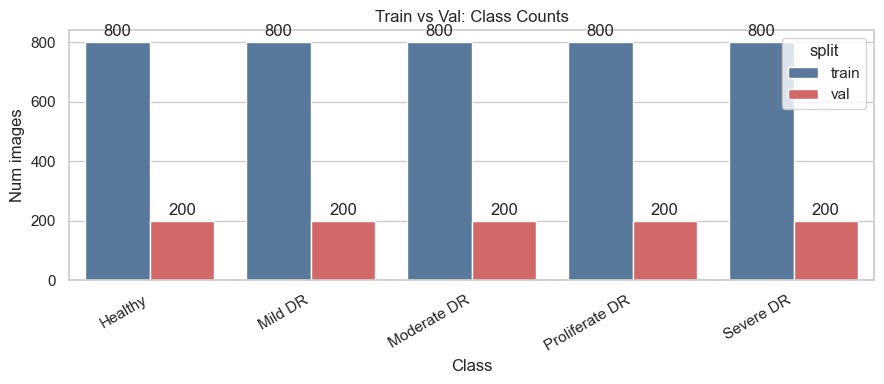

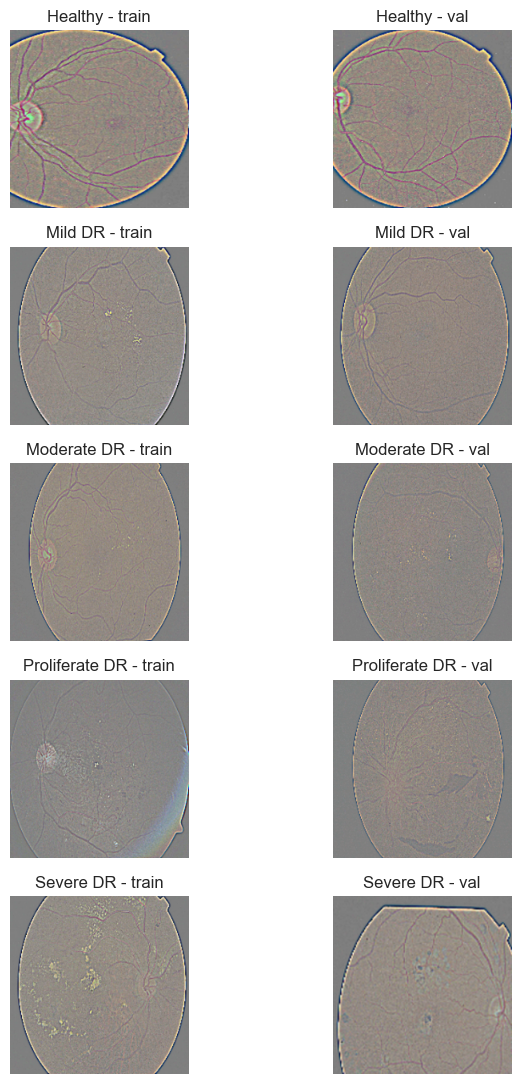

In [28]:
# Visualize train/val split: class counts and sample grid
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

SPLITS_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\splits")

rows = []
for split in ['train', 'val']:
    split_dir = SPLITS_DIR / split
    if not split_dir.exists():
        continue
    for class_dir in sorted([d for d in split_dir.iterdir() if d.is_dir()]):
        cls = class_dir.name
        for p in class_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}:
                rows.append({'split': split, 'class': cls, 'path': str(p)})

df_split = pd.DataFrame(rows)
if df_split.empty:
    print('No images found under splits folder:', SPLITS_DIR)
else:
    # Side-by-side bar chart of class counts per split
    sns.set_theme(style='whitegrid')
    counts = (df_split.groupby(['split','class'])['path']
                    .count().reset_index(name='count'))
    classes = sorted(counts['class'].unique())

    plt.figure(figsize=(9, 4))
    ax = sns.barplot(data=counts, x='class', y='count', hue='split', palette=['#4C78A8','#E45756'], order=classes)
    plt.title('Train vs Val: Class Counts')
    plt.xlabel('Class')
    plt.ylabel('Num images')
    plt.xticks(rotation=30, ha='right')
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', label_type='edge', padding=2)
    plt.tight_layout()
    plt.show()


    # Sample grid: one example per class per split (2 columns: train vs val)
    n_rows = len(classes)
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 2.2*max(1, n_rows)))
    if n_rows == 1:
        axes = np.array([axes])
    for i, cls in enumerate(classes):
        for j, split in enumerate(['train', 'val']):
            ax = axes[i, j]
            ax.axis('off')
            subset = df_split[(df_split['class'] == cls) & (df_split['split'] == split)]
            ax.set_title(f"{cls} - {split}")
            if not subset.empty:
                path = subset['path'].iloc[0]
                try:
                    img = Image.open(path).convert('RGB')
                    ax.imshow(img)
                except Exception:
                    ax.text(0.5, 0.5, 'load error', ha='center', va='center')
            else:
                ax.text(0.5, 0.5, 'none', ha='center', va='center')
    plt.tight_layout()
    plt.show()


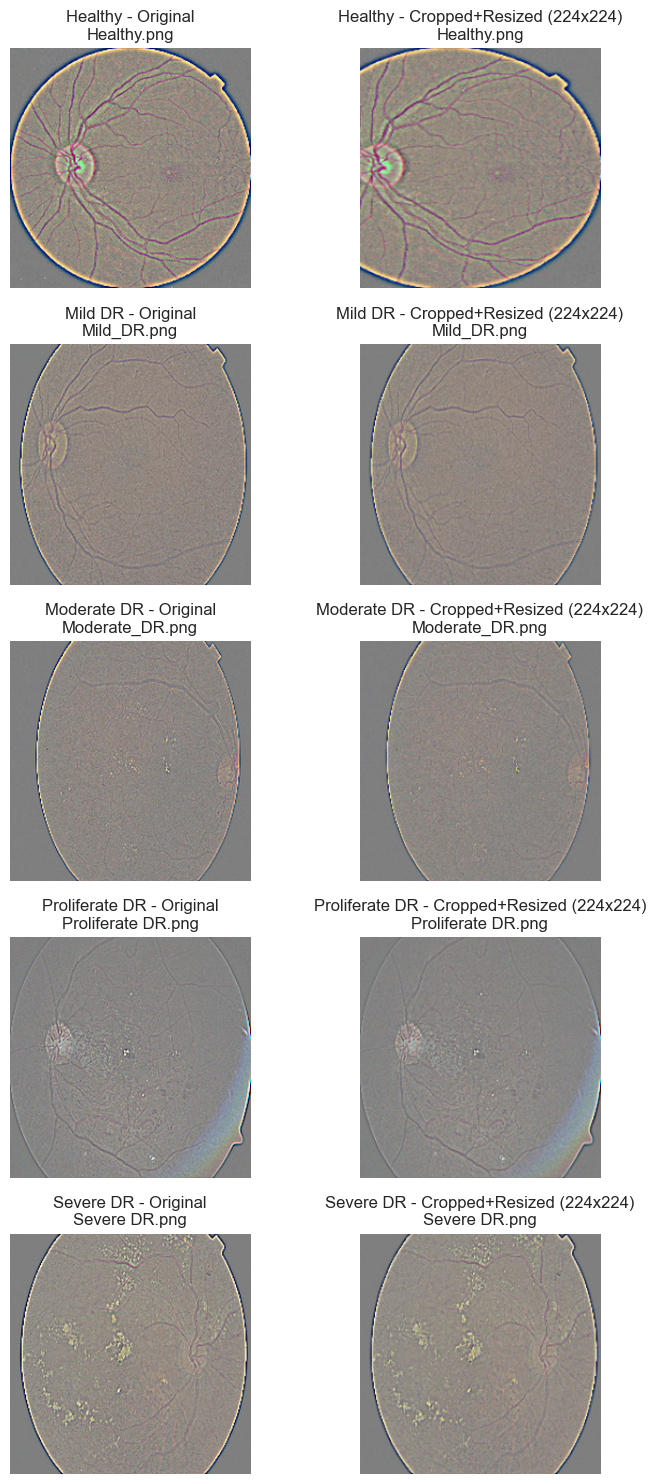

In [31]:
# One example per class: original vs cropped+resized
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Reuse the same dirs as before; change if needed
ORIG_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR")
PROC_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224")

IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

pairs = []
for class_dir in sorted([d for d in PROC_DIR.iterdir() if d.is_dir()]):
    cls = class_dir.name
    # pick the first processed file that has a matching original name
    for p in class_dir.rglob('*'):
        if p.is_file() and p.suffix.lower() in IMG_EXT:
            orig = ORIG_DIR / cls / p.name
            if orig.exists():
                pairs.append((cls, orig, p))
                break

if not pairs:
    print('No matching (original, processed) pairs found. Check ORIG_DIR/PROC_DIR or filenames.')
else:
    n = len(pairs)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(8, 3*n))
    if n == 1:
        axes = np.array([axes])
    for i, (cls, orig_p, proc_p) in enumerate(pairs):
        ax1, ax2 = axes[i]
        ax1.axis('off'); ax2.axis('off')
        try:
            orig = Image.open(orig_p).convert('RGB')
            proc = Image.open(proc_p).convert('RGB')
            ax1.imshow(orig); ax1.set_title(f"{cls} - Original\n{orig_p.name}")
            ax2.imshow(proc); ax2.set_title(f"{cls} - Cropped+Resized ({proc.size[0]}x{proc.size[1]})\n{proc_p.name}")
        except Exception:
            ax1.text(0.5, 0.5, 'load error', ha='center', va='center')
            ax2.text(0.5, 0.5, 'load error', ha='center', va='center')
    plt.tight_layout()
    plt.show()


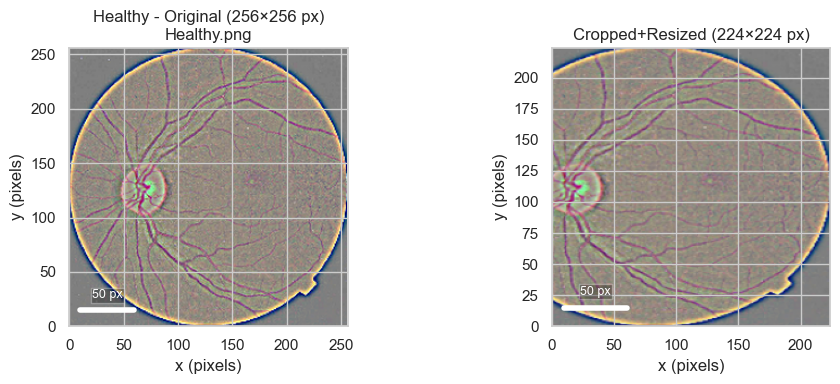

In [34]:
# Show one image with pixel scales: original vs resized (with scale bars)
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

ORIG_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR")
PROC_DIR = Path(r"C:\Users\KIRITI\Downloads\DR\Dataset_DR_224")

IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

# Find one matching pair (same filename under same class)
pair = None
for class_dir in sorted([d for d in PROC_DIR.iterdir() if d.is_dir()]):
    cls = class_dir.name
    for p in class_dir.rglob('*'):
        if p.is_file() and p.suffix.lower() in IMG_EXT:
            orig = ORIG_DIR / cls / p.name
            if orig.exists():
                pair = (cls, orig, p)
                break
    if pair:
        break

if not pair:
    print('No matching (original, processed) pair found. Adjust ORIG_DIR/PROC_DIR.')
else:
    cls, orig_p, proc_p = pair
    orig = np.array(Image.open(orig_p).convert('RGB'))
    proc = np.array(Image.open(proc_p).convert('RGB'))

    def add_scale_bar(ax, length_px=50, color='white', linewidth=4, pad=10):
        h, w = ax.images[0].get_array().shape[:2]
        x0 = pad
        y0 = pad + 5  # place near bottom with origin='lower'
        ax.plot([x0, x0+length_px], [y0, y0], color=color, linewidth=linewidth)
        ax.text(x0+length_px/2, y0+8, f"{length_px} px", color=color,
                ha='center', va='bottom', fontsize=9, bbox=dict(facecolor='black', alpha=0.3, pad=1))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Original with axes in pixels (y increases upward)
    axes[0].imshow(orig, origin='lower')
    axes[0].set_title(f"{cls} - Original ({orig.shape[1]}×{orig.shape[0]} px)\n{orig_p.name}")
    axes[0].set_xlabel('x (pixels)'); axes[0].set_ylabel('y (pixels)')
    add_scale_bar(axes[0], length_px=max(50, min(200, orig.shape[1]//6)))

    # Resized with axes in pixels (y increases upward)
    axes[1].imshow(proc, origin='lower')
    axes[1].set_title(f"Cropped+Resized ({proc.shape[1]}×{proc.shape[0]} px)")
    axes[1].set_xlabel('x (pixels)'); axes[1].set_ylabel('y (pixels)')
    add_scale_bar(axes[1], length_px=50)

    for ax in axes:
        h, w = ax.images[0].get_array().shape[:2]
        ax.set_xlim(0, w)
        ax.set_ylim(0, h)  # standard Cartesian: y increases upward

    plt.tight_layout()
    plt.show()


In [ ]:
# ResNet-101 training configuration
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Deterministic behaviour for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("splits")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR = DATA_ROOT / "val"
OUTPUT_WEIGHTS = Path("resnet101_dr_best.pth")

BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 3  # early stop epochs without improvement
NUM_WORKERS = 0  # Windows DataLoader safety

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Train dir: {TRAIN_DIR}")
print(f"Val dir  : {VAL_DIR}")


In [ ]:
# Build datasets and dataloaders
if not TRAIN_DIR.exists() or not VAL_DIR.exists():
    raise FileNotFoundError("Train/Val directories not found. Run the splitting cell first.")

weights = models.ResNet101_Weights.IMAGENET1K_V2
preprocess = weights.transforms()
mean, std = preprocess.mean, preprocess.std

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=False)

train_counts = Counter(train_dataset.targets)
total_samples = len(train_dataset)
class_weights = torch.tensor([
    total_samples / (num_classes * train_counts[i]) for i in range(num_classes)
], dtype=torch.float32)
print("Class counts:", {class_names[i]: train_counts[i] for i in range(num_classes)})
print("Class weights:", class_weights.tolist())


In [ ]:
# Define ResNet-101 model, optimizer, scheduler
model = models.resnet101(weights=weights)
for param in model.parameters():
    param.requires_grad = False  # freeze backbone for fast convergence

# Unfreeze last residual block for more capacity
for param in model.layer4.parameters():
    param.requires_grad = True

in_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4),
    torch.nn.Linear(in_features, num_classes)
)
model = model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


In [ ]:
# Training loop with early stopping
history = []
best_val_acc = 0.0
patience_counter = 0

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_examples = 0

    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_examples += labels.size(0)

    scheduler.step()

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_examples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_examples += labels.size(0)

    train_loss /= max(1, train_examples)
    train_acc = train_correct / max(1, train_examples)
    val_loss /= max(1, val_examples)
    val_acc = val_correct / max(1, val_examples)

    history.append({
        'epoch': epoch,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
    })

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} | "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), OUTPUT_WEIGHTS)
        print(f"  -> New best model saved ({best_val_acc:.4f})")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

print("Training complete. Best val acc:", best_val_acc)
if not OUTPUT_WEIGHTS.exists():
    torch.save(model.state_dict(), OUTPUT_WEIGHTS)
    print("Saved final model despite no improvement (safety).")


In [ ]:
# Evaluation helpers: load best checkpoint, plot curves, report metrics
if OUTPUT_WEIGHTS.exists():
    model.load_state_dict(torch.load(OUTPUT_WEIGHTS, map_location=DEVICE))
    print(f"Loaded best weights from {OUTPUT_WEIGHTS}")
else:
    print("Warning: best weights not found, using current model state")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix (ResNet-101)')
plt.show()

if history:
    epochs = [h['epoch'] for h in history]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, [h['train_loss'] for h in history], label='Train')
    plt.plot(epochs, [h['val_loss'] for h in history], label='Val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [h['train_acc'] for h in history], label='Train')
    plt.plot(epochs, [h['val_acc'] for h in history], label='Val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('No training history captured.')
